# Deep learning model VGG

In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from torch.nn.functional import interpolate
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nibabel as nib
import os
import gc

In [2]:
!pwd

/home/ljd2160


In [3]:
device = torch.device("cuda:1")
device

device(type='cuda', index=1)

# Dataloader

In [4]:
data_path = "~/research/OASIS1/LST/S0001"
annotations_file = "~/research/OASIS1/oasis_cross-sectional.csv"

In [5]:
class downsample(object):
    def __init__(self, downscale_factor):
        self.downscale_factor = downscale_factor

    def __call__(self, sample):
        sample = sample.float()
        original_size = sample.size()
        new_size = [int(original_size[0] * self.downscale_factor),
                    int(original_size[1] * self.downscale_factor),
                    int(original_size[2] * self.downscale_factor)]
        downsampled_image = interpolate(sample.unsqueeze(0).unsqueeze(0), size = new_size, mode='trilinear', align_corners = False)
        downsampled_image = downsampled_image.squeeze(0)
        return downsampled_image

In [6]:
class OASIS(Dataset):
    def __init__(self, annotations_file, data_path, transform = None):
        # clean up the csv file so that only the ID and CDR columns are left
        self.labels = pd.read_csv(annotations_file)
        self.labels = self.labels[['ID', 'CDR']]
        self.labels = self.labels.dropna(subset=['CDR'])
        self.labels = self.labels.reset_index(drop=True)
        self.labels['CDR'] = [1 if i> 0 else 0 for i in self.labels['CDR']]

        self.data_path = data_path

        self.transform = transform

    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, idx):
        img_filename = self.labels.iloc[idx, 0].replace("MR1", "S0001_T1_O_nu_acpc.nii")
        img_path = os.path.join(data_path, img_filename)
        nifti = nib.load(img_path)
        img = np.float32(nifti.get_fdata())
        img = torch.from_numpy(img)
        if self.transform:
            img = self.transform(img)
        label = self.labels.iloc[idx, 1]
        return img, label

        

## test dataloader

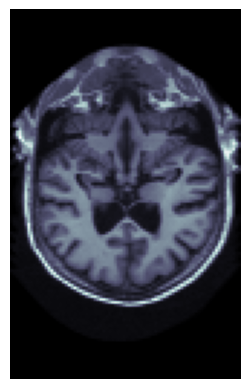

0
torch.Size([1, 128, 128, 80])


In [7]:
halfsample = downsample(0.5)
oasis = OASIS(annotations_file, data_path, halfsample)
img, label = oasis[0]
plt.imshow(img[0][50], cmap = 'bone')
plt.axis('off')
plt.show()
print(label)
print(img.shape)

## test and train split

In [8]:
train_size = int(0.8 * len(oasis))
valid_size = int(0.1 * len(oasis))
test_size = len(oasis) - train_size - valid_size
train_dataset, valid_dataset, test_dataset = random_split(oasis, [train_size, valid_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size = 2, shuffle= True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True)
print(f"train size: {train_size}, validation size:  {valid_size}, test size:  {test_size}")

train size: 188, validation size:  23, test size:  24


torch.Size([2, 1, 128, 128, 80])

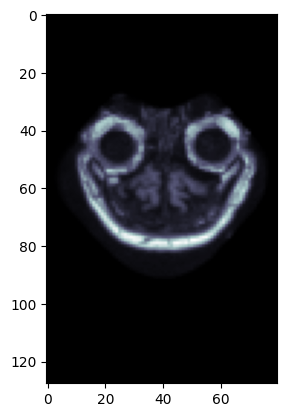

In [9]:
sample = next(iter(train_loader))
plt.imshow(sample[0][0][0][96], cmap = 'bone')
sample[0].shape

# NeuralNetwork

In [24]:
class vgg11(nn.Module):
    def __init__(self, num_channels, n_classes):
        super(vgg11, self).__init__()
        self.features = nn.Sequential(
            nn.Conv3d(num_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2),
            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2),
            nn.Conv3d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2),
            nn.Conv3d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2),
            nn.Conv3d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 1000), 
            nn.ReLU(inplace=True),
            nn.Linear(1000, n_classes),
            nn.Sigmoid()
        )   

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x.squeeze(1)
    
my_vgg = vgg11(1, 1)

# Training

In [25]:
optimizer = torch.optim.Adam(my_vgg.parameters(), lr=0.01)
loss_function = nn.BCELoss()

In [17]:
def train_net(net, epochs, train_dataloader, valid_loader, optimizer, loss_function):
    ret_train_loss = []
    ret_valid_loss = []
    for epoch in range(epochs):
        net.train()

        train_loss = []
        for i, (img, label) in enumerate(train_dataloader):
            img = img.to(device)
            label = label.to(device)
            optimizer.zero_grad()
            y_pred = net(img)
            loss = loss_function(y_pred, label.float())
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        epoch_loss = np.mean(train_loss)
        ret_train_loss.append(epoch_loss)

        print(f"epoch {epoch}, training loss: {epoch_loss}")
        
        net.eval()

        valid_loss = []
        for i, (img, label) in enumerate(valid_loader):
            img = img.to(device)
            label = label.to(device)
            y_pred = net(img)
            loss = loss_function(y_pred, label.float())
            valid_loss.append(loss.item())
        epoch_vloss = np.mean(valid_loss)
        print(f"epoch {epoch}, validation loss: {epoch_vloss}")
        ret_valid_loss.append(epoch_vloss)

    return ret_train_loss, ret_valid_loss 

In [16]:
def test_net(net, test_dataloader):
    net.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for i, (img, label) in enumerate(test_dataloader):
            img = img.to(device)
            label = label.to(device)
            y_pred = net(img)
            y_pred = torch.round(y_pred)
            total += label.size(0)
            correct += (y_pred == label).sum().item()
        print(f'Accuracy: {correct/total}')

In [26]:
torch.cuda.set_device(device)
gc.collect()
torch.cuda.empty_cache()

In [28]:
my_vgg.to(device)
train_loss, valid_loss = train_net(my_vgg, 10, train_loader, valid_loader, optimizer, loss_function)

epoch 0, training loss: 40.433032621728614
epoch 0, validation loss: 58.333333333333336
epoch 1, training loss: 40.42553191489362
epoch 1, validation loss: 62.5
epoch 2, training loss: 40.42553191489362
epoch 2, validation loss: 62.5
epoch 3, training loss: 40.42553191489362
epoch 3, validation loss: 62.5
epoch 4, training loss: 40.42553191489362
epoch 4, validation loss: 58.333333333333336
epoch 5, training loss: 40.42553191489362
epoch 5, validation loss: 62.5
epoch 6, training loss: 40.42553191489362
epoch 6, validation loss: 62.5
epoch 7, training loss: 40.42553191489362
epoch 7, validation loss: 62.5
epoch 8, training loss: 40.42553191489362
epoch 8, validation loss: 62.5
epoch 9, training loss: 40.42553191489362
epoch 9, validation loss: 62.5


In [ ]:
test_net(my_vgg, test_loader)

Accuracy: 0.5833333333333334
